Note: This notebook has widgets to select the state, congressional district and facility. Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Water Act Inspections by Congressional District

This notebook examines ECHO data using ECHO_EXPORTER and NPDES_INSPECTIONS.

From ECHO_EXPORTER:
<ul>
    <li>NPDES_IDS - to match facilities/violations in NPDES_INPSECTIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>CWA_PERMIT_TYPES</li>
</ul>

CWA Permit Types include:
<ul>
    <li>Major = Publicly Owned Treatment Works (POTW) Handling at least 1 Million gallons per day as well as other major projects.</li>
    <li>Minor = Any other project.</li>
</ul>

From NPDES_INSPECTIONS we get:
<ul>
    <li>COMP_MONITORING_TYPE - a description of the evaluation</li>
    <li>STATE_EPA_FLAG - the agency that conducted the evaluation</li>
    <li>ACTUAL_BEGIN_DATE</li>
</ul>

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [0]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [3]:
my_state = dropdown_state.value

sql = "select FAC_NAME,  FAC_STATE, FAC_LAT, FAC_LONG, NPDES_IDS, CWA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where NPDES_FLAG = 'Y'  and FAC_STATE = '%s'" %(my_state)
print(sql)
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(data_location)

select FAC_NAME,  FAC_STATE, FAC_LAT, FAC_LONG, NPDES_IDS, CWA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where NPDES_FLAG = 'Y'  and FAC_STATE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20NPDES_IDS%2C%20CWA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20NPDES_FLAG%20%3D%20%27Y%27%20%20and%20FAC_STATE%20%3D%20%27NY%27


In [4]:
echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
num_facilities = echo_data.shape[0]

print("There are %s NDIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 10202 NDIS facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [5]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [6]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s NDIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 304 NDIS facilities in NY district 2 tracked in the ECHO database.


Next look up the inspection history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [7]:
sql = "select NPDES_ID, AGENCY, ENF_TYPE_DESC, SETTLEMENT_ENTERED_DATE" + \
        " from NPDES_FORMAL_ENFORCEMENT_ACTIONS  where NPDES_ID like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
#print(data_location)
npdes_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
npdes_data.set_index( "NPDES_ID", inplace=True)
npdes_data

,AGENCY,ENF_TYPE_DESC,SETTLEMENT_ENTERED_DATE
NPDES_ID,,,
NY0000078,EPA,CWA 309A AO For Compliance,04/28/1993
NY0000078,State,State CWA Non Penalty AO,06/17/1985
NY0000078,State,State CWA Non Penalty AO,06/18/1985
NY0000078,EPA,CWA 309G2B AO For Class II Penalties,08/02/1993
NY0000132,EPA,CWA 309A AO For Compliance,08/27/1991
...,...,...,...
NYU900479,State,State Administrative Order of Consent,08/02/2018
NYU900480,State,State Administrative Order of Consent,04/30/2018
NYU900481,State,State Administrative Order of Consent,06/14/2018


In [8]:
# The NPDES_IDS in ECHO_EXPORTER can contain multiple ids for a facility. 
# The string must be parsed to get each individual NPDES_ID to look up 
# in NPDES_INSPECTIONS.

my_cd_npdes = pd.DataFrame()
no_data_ids = []
for fac in my_cd_facs.itertuples():
    ids = fac.NPDES_IDS
    for npdes_id in ids.split():
        try:
            npdes_fac = npdes_data.loc[ npdes_id ].copy()
            # Add the facility's index number to npdes_data, to refer to it.
            n = npdes_fac.shape[0]
            fac_list = [fac.Index] * n
            npdes_fac['facility'] = fac_list
            frames = [my_cd_npdes, npdes_fac]
            my_cd_npdes = pd.concat( frames )
        except KeyError:
            no_data_ids.append( npdes_id )
          
my_cd_npdes

,0,AGENCY,ENF_TYPE_DESC,SETTLEMENT_ENTERED_DATE,facility
AGENCY,EPA,NaN,NaN,NaN,NaN
ENF_TYPE_DESC,CWA 309A AO For Compliance,NaN,NaN,NaN,NaN
SETTLEMENT_ENTERED_DATE,02/11/2019,NaN,NaN,NaN,NaN
facility,"[50, 50, 50]",NaN,NaN,NaN,NaN
NY0065391,NaN,State,State Administrative Order of Consent,04/06/2016,116.0
...,...,...,...,...,...
NY0197432,NaN,State,State Administrative Order of Consent,09/25/2009,10134.0
AGENCY,State,NaN,NaN,NaN,NaN
ENF_TYPE_DESC,State Administrative Order of Consent,NaN,NaN,NaN,NaN
SETTLEMENT_ENTERED_DATE,04/27/2012,NaN,NaN,NaN,NaN


Map the facilities that have had these serious CWA violations.

In [9]:
fac_idx_list = my_cd_npdes['facility'].dropna()
fac_cd_npdes = my_cd_facs.loc[fac_idx_list]
fac_cd_npdes

,FAC_NAME,FAC_STATE,FAC_LAT,FAC_LONG,NPDES_IDS,CWA_PERMIT_TYPES,FAC_DERIVED_CD113
116.0,QUAIL RUN HOMEOWNERS ASSOC,NY,40.757833,-73.312639,NY0065391,Minor,2.0
116.0,QUAIL RUN HOMEOWNERS ASSOC,NY,40.757833,-73.312639,NY0065391,Minor,2.0
388.0,LAUNDRY PALACE CI,NY,40.790940,-73.200810,NY0211591,Minor,2.0
388.0,LAUNDRY PALACE CI,NY,40.790940,-73.200810,NY0211591,Minor,2.0
621.0,HEATHERWOOD HOUSE @ LAKELAND,NY,40.798480,-73.136000,NY0077321,Minor,2.0
...,...,...,...,...,...,...,...
10110.0,HAWTHORNE COURT,NY,40.799972,-73.194361,NY0077402,Minor,2.0
10110.0,HAWTHORNE COURT,NY,40.799972,-73.194361,NY0077402,Minor,2.0
10110.0,HAWTHORNE COURT,NY,40.799972,-73.194361,NY0077402,Minor,2.0
10134.0,MACARTHUR PLAZA OFFICE PARK,NY,40.782370,-73.095730,NY0197432,Minor,2.0


In [10]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_cd = mapper(fac_cd_npdes)
map_of_facilities_in_cd

Present another dropdown with the list of names of the facilities.  Choosing a facility will display the evaluations.

In [11]:
cd_array = fac_cd_npdes["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('ABBE LABORATORIES', 'AFFINITY SKILLED LIVING STP', 'BABYLON (…

Run this next cell after choosing a facility.

CWA Permit Types:
<ul>
    <li>Major = Publicly Owned Treatment Works (POTW) Handling at least 1 Million gallons per day as well as other major projects.</li>
    <li>Minor = Any other project.</li>
</ul>

In [12]:
my_fac = fac_cd_npdes[fac_cd_npdes["FAC_NAME"] == w3.value]
evaluations = my_cd_npdes[my_cd_npdes['facility'] == my_fac.iloc[[0]].index[0]]
print( my_fac.iloc[0] )
evaluations

FAC_NAME             BRENTWOOD LAUNDROMAT
FAC_STATE                              NY
FAC_LAT                            40.779
FAC_LONG                         -73.2272
NPDES_IDS                       NY0104671
CWA_PERMIT_TYPES                    Minor
FAC_DERIVED_CD113                       2
Name: 3897.0, dtype: object


,0,AGENCY,ENF_TYPE_DESC,SETTLEMENT_ENTERED_DATE,facility
NY0104671,NaN,State,State Administrative Order of Consent,04/18/2006,3897.0
NY0104671,NaN,State,State Administrative Order of Consent,06/23/2004,3897.0
NY0104671,NaN,State,State Administrative Order of Consent,08/13/2019,3897.0


In [0]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of enforcements by year for the congressional district.

                  YEAR_ENFORCEMENT
YEAR_ENFORCEMENT                  
1984.0                           1
1985.0                           1
1986.0                           2
1987.0                           3
1988.0                           2
1989.0                           6
1990.0                           1
1992.0                           1
1995.0                           2
1997.0                           4
1999.0                           1
2000.0                           3
2001.0                           1
2003.0                           1
2004.0                           1
2005.0                           3
2006.0                           4
2008.0                          11
2009.0                          11
2010.0                           3
2011.0                           4
2013.0                           3
2014.0                           7
2015.0                           6
2016.0                          12
2017.0                           6
2018.0              

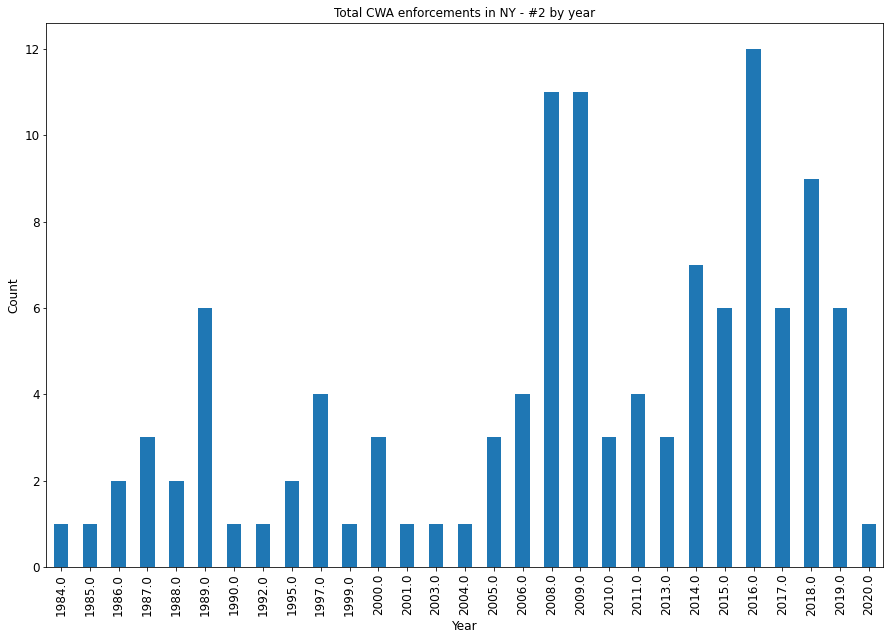

In [14]:
chart_title = "Total CWA enforcements"

show_plot( my_cd_npdes, 'SETTLEMENT_ENTERED_DATE', 'YEAR_ENFORCEMENT', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of evaluations by year, using the entire state.
Since the number of evaluations in a single CD may be small, it can be more
interesting to look at the entire state.

                  YEAR_ENFORCEMENT
YEAR_ENFORCEMENT                  
1984.0                           1
1985.0                           1
1986.0                           2
1987.0                           3
1988.0                           2
1989.0                           6
1990.0                           1
1992.0                           1
1995.0                           2
1997.0                           4
1999.0                           1
2000.0                           3
2001.0                           1
2003.0                           1
2004.0                           1
2005.0                           3
2006.0                           4
2008.0                          11
2009.0                          11
2010.0                           3
2011.0                           4
2013.0                           3
2014.0                           7
2015.0                           6
2016.0                          12
2017.0                           6
2018.0              

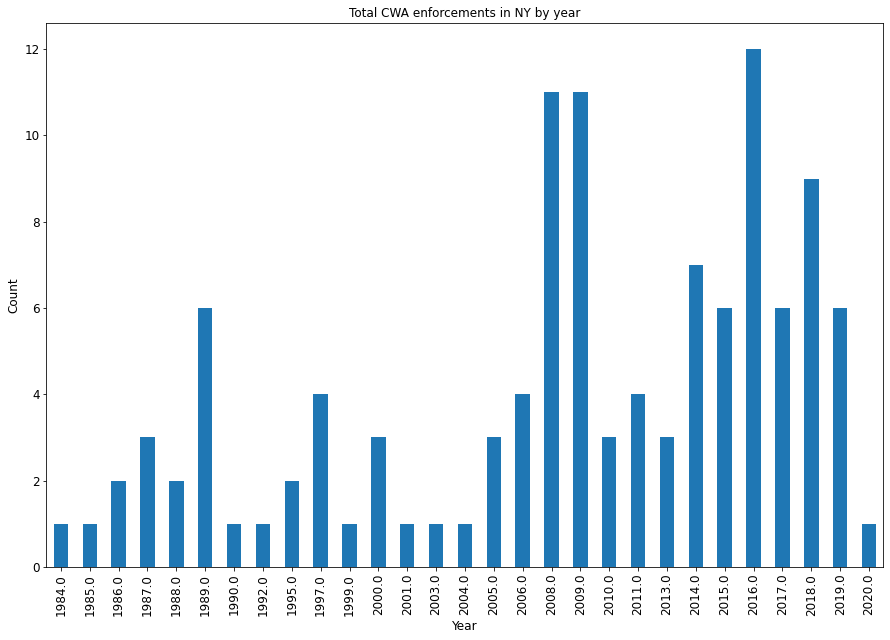

In [15]:
show_plot( my_cd_npdes, 'SETTLEMENT_ENTERED_DATE', 'YEAR_ENFORCEMENT', \
          my_state, '%m/%d/%Y', chart_title )